# Notebook 10 - RAPIDS + cuOpt Benchmark (Side Task)

Objective: measure practical acceleration value from `cuDF`, `cuML`, `cuGraph`, `cuOpt` on Lending Club data.

Scope boundary:
- This notebook is independent from the canonical project pipeline.
- It does not modify core project artifacts or acceptance gates.


## Official references (current docs)

- RAPIDS install + platform support: https://docs.rapids.ai/install
- cuDF pandas accelerator: https://docs.rapids.ai/api/cudf/stable/cudf_pandas/
- cuDF + Polars GPU engine: https://docs.rapids.ai/api/cudf/stable/cudf_polars/usage/
- cuML API: https://docs.rapids.ai/api/cuml/stable/api/
- cuGraph API (including non-convergence handling): https://docs.rapids.ai/api/cugraph/stable/api_docs/api/cugraph/cugraph.pagerank/
- nx-cugraph backend usage: https://docs.rapids.ai/api/cugraph/stable/nx_cugraph/
- RMM CuPy allocator: https://docs.rapids.ai/api/rmm/nightly/python_api/
- cuOpt LP Python API: https://docs.nvidia.com/cuopt/user-guide/latest/cuopt-python/lp-milp-examples.html


In [29]:
from __future__ import annotations

import importlib.util
import json
import subprocess
import sys
import textwrap
import time
import traceback
from pathlib import Path
from typing import Any

import numpy as np
import pandas as pd
import polars as pl
from IPython.display import display


def find_root(start: Path | None = None) -> Path:
    cur = (start or Path.cwd()).resolve()
    for p in [cur] + list(cur.parents):
        if (p / "data").exists() and (p / "notebooks").exists():
            return p
    raise FileNotFoundError("No project root found")


ROOT = find_root()
DATA = ROOT / "data" / "processed"
OUT = ROOT / "reports" / "gpu_benchmark"
OUT.mkdir(parents=True, exist_ok=True)

TRAIN = DATA / "train.parquet"
TEST = DATA / "test.parquet"
TRAIN_FE = DATA / "train_fe.parquet"
TEST_FE = DATA / "test_fe.parquet"

CONFIG: dict[str, Any] = {
    "seed": 42,
    "save_outputs": False,
    "cudf_repeats": 4,
    "cudf_warmup": 1,
    "cuml_train_sample": 250_000,
    "cuml_test_sample": 100_000,
    "cuml_repeats_light": 2,
    "cuml_repeats_heavy": 1,
    "cugraph_sample_rows": 30_000,
    "cugraph_repeats": 3,
    "cuopt_sample_rows": 18_000,
    "cuopt_repeats": 3,
    "consistency_rel_tol": 5e-3,
    "plot_per_method_charts": True,
}


def stats_from(values: list[float]) -> dict[str, float]:
    arr = np.asarray(values, dtype=np.float64)
    if arr.size == 0:
        return {
            "median_seconds": np.nan,
            "mean_seconds": np.nan,
            "std_seconds": np.nan,
            "iqr_seconds": np.nan,
        }
    q1, q3 = np.percentile(arr, [25, 75])
    return {
        "median_seconds": float(np.median(arr)),
        "mean_seconds": float(np.mean(arr)),
        "std_seconds": float(np.std(arr)),
        "iqr_seconds": float(q3 - q1),
    }


def rel_err(a: float, b: float) -> float:
    den = max(abs(a), 1e-12)
    return float(abs(a - b) / den)


def maybe_save(df: pd.DataFrame, name: str) -> None:
    if CONFIG["save_outputs"]:
        out = OUT / name
        df.to_csv(out, index=False)
        print("Saved:", out)


try:
    import matplotlib.pyplot as plt

    HAS_MPL = True
    plt.style.use("seaborn-v0_8-whitegrid")
except Exception as exc:
    HAS_MPL = False
    print("matplotlib unavailable:", repr(exc))


CPU_COLOR = "#A8B5C4"
GPU_GAIN_COLOR = "#94C9B2"
GPU_LOSS_COLOR = "#E8A7A7"
TEXT_SOFT = "#5B6470"


def classify_relevance(speedup_x: float, seconds_saved: float, quality_pass: bool) -> str:
    if not quality_pass:
        return "No concluyente (quality check fail)"
    if not np.isfinite(speedup_x):
        return "No disponible"
    if speedup_x >= 3.0 and seconds_saved >= 0.05:
        return "Alta relevancia"
    if speedup_x >= 1.5 and seconds_saved >= 0.01:
        return "Relevancia moderada"
    if speedup_x >= 1.1:
        return "Relevancia baja"
    if speedup_x >= 0.9:
        return "Neutro"
    return "No relevante (CPU mejor)"


def finalize_direct_df(df: pd.DataFrame, section_name: str) -> pd.DataFrame:
    if df is None or len(df) == 0:
        print(f"[{section_name}] No direct CPU/GPU pairs available.")
        return pd.DataFrame()
    out = df.copy()
    out["improvement_pct"] = (out["speedup_x"] - 1.0) * 100.0
    out["seconds_saved"] = out["cpu_seconds"] - out["gpu_seconds"]
    out["relevance"] = [
        classify_relevance(sp, ss, qp)
        for sp, ss, qp in zip(
            out["speedup_x"].to_numpy(np.float64),
            out["seconds_saved"].to_numpy(np.float64),
            out["quality_pass"].to_numpy(bool),
        )
    ]
    order = [
        "section",
        "method",
        "cpu_backend",
        "gpu_backend",
        "cpu_seconds",
        "gpu_seconds",
        "speedup_x",
        "improvement_pct",
        "seconds_saved",
        "quality_pass",
        "relevance",
        "note",
    ]
    keep = [c for c in order if c in out.columns]
    return out[keep].sort_values(["section", "method"]).reset_index(drop=True)


def plot_method_pairs(direct_df: pd.DataFrame, section_title: str) -> None:
    if not bool(CONFIG.get("plot_per_method_charts", True)):
        return
    if not HAS_MPL or direct_df is None or len(direct_df) == 0:
        return
    print(f"{section_title}: gráficos CPU vs GPU por método")
    for _, r in direct_df.iterrows():
        method = str(r["method"])
        cpu_s = float(r["cpu_seconds"])
        gpu_s = float(r["gpu_seconds"])
        speedup = float(r["speedup_x"])
        improvement = float(r["improvement_pct"])
        qpass = bool(r["quality_pass"])
        relevance = str(r["relevance"])
        note = str(r.get("note", "")).strip()

        fig, ax = plt.subplots(figsize=(8.6, 4.2))
        gpu_color = GPU_GAIN_COLOR if improvement >= 0 else GPU_LOSS_COLOR
        bars = ax.barh(["CPU", "GPU"], [cpu_s, gpu_s], color=[CPU_COLOR, gpu_color], height=0.56)

        positive = [v for v in [cpu_s, gpu_s] if np.isfinite(v) and v > 0]
        if len(positive) == 2 and max(positive) / min(positive) >= 30:
            ax.set_xscale("log")
            ax.set_xlabel("Median seconds (log scale)")
        else:
            ax.set_xlabel("Median seconds")

        xmax = max(positive) if positive else 1.0
        ax.set_xlim(0, xmax * 1.35 if np.isfinite(xmax) else 1.0)
        for b, v in zip(bars, [cpu_s, gpu_s]):
            ax.text(
                b.get_width() + xmax * 0.025,
                b.get_y() + b.get_height() / 2,
                f"{v:.4f}s",
                ha="left",
                va="center",
                fontsize=10,
                color="#374151",
            )

        ax.set_title(f"{section_title} | {method}", loc="left", fontsize=13, fontweight="bold", pad=14)
        subtitle = (
            f"speedup={speedup:.2f}x | improvement={improvement:+.1f}% | "
            f"quality_pass={qpass} | {relevance}"
        )
        ax.text(0.00, 1.02, subtitle, transform=ax.transAxes, fontsize=10, color=TEXT_SOFT, va="bottom")
        if note:
            ax.text(0.00, -0.24, f"detalle: {note[:120]}", transform=ax.transAxes, fontsize=9, color=TEXT_SOFT)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(axis="x", alpha=0.18)
        fig.subplots_adjust(left=0.16, right=0.96, top=0.80, bottom=0.24)
        plt.show()


def print_section_conclusions(direct_df: pd.DataFrame, section_title: str) -> None:
    if direct_df is None or len(direct_df) == 0:
        return
    best = direct_df.sort_values("speedup_x", ascending=False).iloc[0]
    worst = direct_df.sort_values("speedup_x", ascending=True).iloc[0]
    pass_rate = float(direct_df["quality_pass"].mean())
    print(
        f"{section_title} conclusions: "
        f"median speedup={float(direct_df['speedup_x'].median()):.2f}x, "
        f"best={best['method']} ({best['speedup_x']:.2f}x), "
        f"worst={worst['method']} ({worst['speedup_x']:.2f}x), "
        f"quality_pass_rate={pass_rate:.2f}"
    )
    for _, r in direct_df.sort_values("speedup_x", ascending=False).iterrows():
        print(
            f"- {r['method']}: {r['speedup_x']:.2f}x ({r['improvement_pct']:+.1f}%), "
            f"{r['relevance']}"
        )


print("ROOT:", ROOT)
print("Python:", sys.executable)
print("save_outputs:", CONFIG["save_outputs"])


ROOT: /home/eigenlinux/projects/lending-club-risk-project
Python: /home/eigenlinux/miniforge3/envs/rapids/bin/python
save_outputs: False


## Environment and data checks

Notes:
- This notebook expects a RAPIDS-capable environment (Linux/WSL2 + NVIDIA GPU).
- CSV export is optional and disabled by default (`CONFIG["save_outputs"] = False`).


In [30]:
# Hardware + package checks

def run(cmd: list[str]) -> tuple[int, str, str]:
    p = subprocess.run(cmd, capture_output=True, text=True)
    return p.returncode, p.stdout, p.stderr

code, out, err = run(["nvidia-smi"])
print(out if code == 0 else err)

pkgs = [
    "cudf", "cuml", "cugraph", "nx_cugraph", "cuopt", "cupy", "rmm",
    "networkx", "scipy", "sklearn", "polars", "pandas",
]
rows = []
for p in pkgs:
    spec = importlib.util.find_spec(p)
    ver = None
    if spec is not None:
        try:
            mod = __import__(p)
            ver = getattr(mod, "__version__", None)
        except Exception:
            ver = "import_error"
    rows.append({"package": p, "available": spec is not None, "version": ver})
display(pd.DataFrame(rows))

# 10GB VRAM-safe RMM pool for RTX 3080 style cards
try:
    import cupy as cp
    import rmm

    rmm.reinitialize(pool_allocator=True, managed_memory=False, initial_pool_size=6 * 1024**3)

    alloc = None
    try:
        from rmm.allocators.cupy import rmm_cupy_allocator

        alloc = rmm_cupy_allocator
    except Exception:
        alloc = getattr(rmm, "rmm_cupy_allocator", None)

    if alloc is not None:
        cp.cuda.set_allocator(alloc)
        print("RMM configured with CuPy allocator")
    else:
        print("RMM configured, but CuPy allocator binding not found")
except Exception as exc:
    print("RMM setup skipped:", repr(exc))

for p in [TRAIN, TEST, TRAIN_FE, TEST_FE]:
    if not p.exists():
        raise FileNotFoundError(f"Missing required file: {p}")

summary = []
for p in [TRAIN, TEST, TRAIN_FE, TEST_FE]:
    d = pd.read_parquet(p, columns=["id", "default_flag"])
    summary.append({
        "file": str(p.relative_to(ROOT)),
        "rows": int(len(d)),
        "default_rate": float(d["default_flag"].mean()),
    })
display(pd.DataFrame(summary))


Mon Feb  9 15:13:54 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 590.57                 Driver Version: 591.86         CUDA Version: 13.1     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080        On  |   00000000:09:00.0  On |                  N/A |
| 55%   50C    P3             71W /  370W |    2594MiB /  10240MiB |     20%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

,package,available,version
0,cudf,True,25.12.00
1,cuml,True,25.12.00
2,cugraph,True,25.12.02
3,nx_cugraph,True,25.12.00
4,cuopt,True,25.12.00
5,cupy,True,13.6.0
6,rmm,True,25.12.00
7,networkx,True,3.6.1
8,scipy,True,1.16.3
9,sklearn,True,1.8.0


RMM configured with CuPy allocator


,file,rows,default_rate
0,data/processed/train.parquet,1346311,0.185232
1,data/processed/test.parquet,276869,0.219779
2,data/processed/train_fe.parquet,1346311,0.185232
3,data/processed/test_fe.parquet,276869,0.219779


## 1) cuDF benchmark (paired consistency checks)

Compared modes:
- `pandas_cpu`
- `pandas_cudf` via `python -m cudf.pandas`
- `polars_cpu`
- `polars_cudf` via `pl.GPUEngine`

Benchmark quality checks:
- Row-count parity against `pandas_cpu`
- Checksum relative error tolerance (`CONFIG["consistency_rel_tol"]`)
- Dedicated CPU-vs-GPU chart per method in this same section


,command,status,returncode,stderr_tail,median_seconds,mean_seconds,std_seconds,iqr_seconds,rows_out,checksum,mode,speedup_vs_pandas_cpu,rows_match_cpu,checksum_rel_err_cpu,consistency_pass
0,/home/eigenlinux/miniforge3/envs/rapids/bin/py...,ok,0,,3.388590,3.373810,0.054722,0.072646,76,3.796756e+09,pandas_cpu,1.000000,1.0,0.000000e+00,1.0
2,/home/eigenlinux/miniforge3/envs/rapids/bin/py...,ok,0,,0.404061,0.402340,0.030466,0.057034,76,3.796756e+09,pandas_cudf,8.386329,1.0,2.511814e-16,1.0
1,/home/eigenlinux/miniforge3/envs/rapids/bin/py...,ok,0,,0.107075,0.108281,0.008799,0.013867,76,3.796756e+09,polars_cpu,31.646893,1.0,1.255907e-16,1.0
3,/home/eigenlinux/miniforge3/envs/rapids/bin/py...,ok,0,,0.087033,0.091322,0.008371,0.006867,76,3.796756e+09,polars_cudf,38.934433,1.0,1.255907e-16,1.0


,section,method,cpu_backend,gpu_backend,cpu_seconds,gpu_seconds,speedup_x,improvement_pct,seconds_saved,quality_pass,relevance,note
0,cudf,pandas_query_pipeline,pandas_cpu,pandas_cudf,3.388590,0.404061,8.386329,738.632893,2.984529,True,Alta relevancia,checksum_rel_err=2.511813639753754e-16
1,cudf,polars_query_pipeline,polars_cpu,polars_cudf,0.107075,0.087033,1.230277,23.027665,0.020042,True,Relevancia baja,checksum_rel_err=1.255906819876877e-16


cuDF: gráficos CPU vs GPU por método


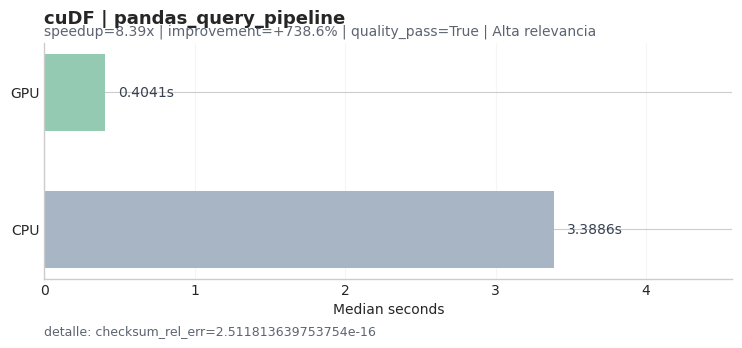

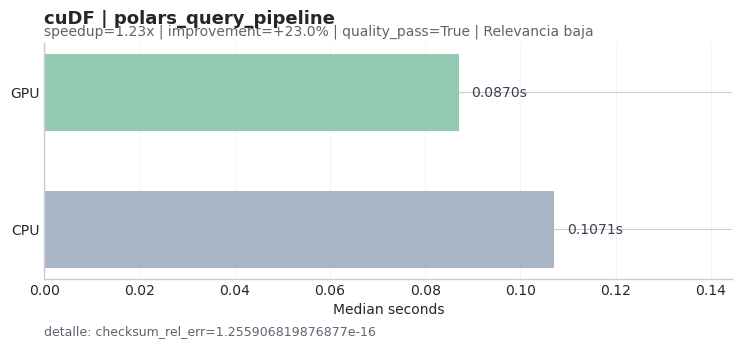

cuDF conclusions: median speedup=4.81x, best=pandas_query_pipeline (8.39x), worst=polars_query_pipeline (1.23x), quality_pass_rate=1.00
- pandas_query_pipeline: 8.39x (+738.6%), Alta relevancia
- polars_query_pipeline: 1.23x (+23.0%), Relevancia baja


In [31]:
TMP = OUT / "tmp_scripts"
TMP.mkdir(parents=True, exist_ok=True)

pandas_script = textwrap.dedent('''
import json, sys, time
import numpy as np
import pandas as pd

path = sys.argv[1]
repeats = int(sys.argv[2])
warmup = int(sys.argv[3])
cols = ["id","issue_d","loan_amnt","int_rate","annual_inc","term","grade","purpose","default_flag"]

def run_once():
    df = pd.read_parquet(path, columns=cols)
    df["int_rate"] = pd.to_numeric(df["int_rate"].astype(str).str.rstrip("%"), errors="coerce")
    df["term_m"] = pd.to_numeric(df["term"].astype(str).str.extract(r"(\d+)")[0], errors="coerce")
    df["issue_d"] = pd.to_datetime(df["issue_d"], errors="coerce")
    df["issue_year"] = df["issue_d"].dt.year.astype("Int64")

    f = df[(df["loan_amnt"] >= 5000) & (df["annual_inc"] > 20000) & (df["term_m"].isin([36, 60]))]
    a = f.groupby(["grade", "issue_year"], dropna=False).agg(
        loans=("id", "count"), funded=("loan_amnt", "sum"), dr=("default_flag", "mean")
    ).reset_index()
    b = f.groupby("purpose", dropna=False).agg(
        p_loans=("id", "count"), p_dr=("default_flag", "mean")
    ).reset_index()
    g = f[["grade", "purpose"]].drop_duplicates("grade")
    z = a.merge(g, on="grade", how="left").merge(b, on="purpose", how="left")
    z["checksum_col"] = z["dr"].fillna(0.0) * z["funded"].fillna(0.0)
    z = z.sort_values(["issue_year", "grade"]).head(5000)
    return z

t = []
out = None
for i in range(repeats + warmup):
    s = time.perf_counter()
    out = run_once()
    dt = time.perf_counter() - s
    if i >= warmup:
        t.append(dt)

arr = np.asarray(t, dtype=np.float64)
q1, q3 = np.percentile(arr, [25, 75])
print(json.dumps({
    "median_seconds": float(np.median(arr)),
    "mean_seconds": float(np.mean(arr)),
    "std_seconds": float(np.std(arr)),
    "iqr_seconds": float(q3 - q1),
    "rows_out": int(len(out)),
    "checksum": float(out["checksum_col"].sum()),
}))
''').strip()

polars_script = textwrap.dedent('''
import json, sys, time
import numpy as np
import polars as pl

path = sys.argv[1]
repeats = int(sys.argv[2])
warmup = int(sys.argv[3])
mode = sys.argv[4]

def run_once(mode):
    lf = pl.scan_parquet(path).select([
        "id", "issue_d", "loan_amnt", "int_rate", "annual_inc", "term", "grade", "purpose", "default_flag"
    ])
    lf = lf.with_columns([
        pl.col("int_rate").cast(pl.Utf8).str.replace("%", "", literal=True).cast(pl.Float64, strict=False),
        pl.col("term").cast(pl.Utf8).str.extract(r"(\d+)", group_index=1).cast(pl.Int32, strict=False).alias("term_m"),
        pl.col("issue_d").cast(pl.Date, strict=False),
    ]).with_columns(pl.col("issue_d").dt.year().alias("issue_year"))

    f = lf.filter((pl.col("loan_amnt") >= 5000) & (pl.col("annual_inc") > 20000) & (pl.col("term_m").is_in([36, 60])))
    a = f.group_by(["grade", "issue_year"]).agg([
        pl.len().alias("loans"),
        pl.sum("loan_amnt").alias("funded"),
        pl.mean("default_flag").alias("dr"),
    ])
    b = f.group_by("purpose").agg([
        pl.len().alias("p_loans"),
        pl.mean("default_flag").alias("p_dr"),
    ])
    g = f.select(["grade", "purpose"]).unique(subset=["grade"], keep="first")

    z = (
        a.join(g, on="grade", how="left")
         .join(b, on="purpose", how="left")
         .with_columns((pl.col("dr").fill_null(0.0) * pl.col("funded").fill_null(0.0)).alias("checksum_col"))
         .sort(["issue_year", "grade"])
         .limit(5000)
    )

    if mode == "gpu":
        if not hasattr(pl, "GPUEngine"):
            raise RuntimeError("Polars GPUEngine is not available")
        out = z.collect(engine=pl.GPUEngine(raise_on_fail=True))
    else:
        out = z.collect()
    return out

t = []
out = None
for i in range(repeats + warmup):
    s = time.perf_counter()
    out = run_once(mode)
    dt = time.perf_counter() - s
    if i >= warmup:
        t.append(dt)

arr = np.asarray(t, dtype=np.float64)
q1, q3 = np.percentile(arr, [25, 75])
print(json.dumps({
    "median_seconds": float(np.median(arr)),
    "mean_seconds": float(np.mean(arr)),
    "std_seconds": float(np.std(arr)),
    "iqr_seconds": float(q3 - q1),
    "rows_out": int(out.height),
    "checksum": float(out["checksum_col"].sum()),
}))
''').strip()

(TMP / "bench_pandas.py").write_text(pandas_script + "\n", encoding="utf-8")
(TMP / "bench_polars.py").write_text(polars_script + "\n", encoding="utf-8")


def run_json(cmd: list[str]) -> dict[str, Any]:
    p = subprocess.run(cmd, cwd=str(ROOT), capture_output=True, text=True)
    res: dict[str, Any] = {
        "command": " ".join(cmd),
        "status": "ok" if p.returncode == 0 else "error",
        "returncode": p.returncode,
        "stderr_tail": p.stderr[-800:],
    }
    if p.returncode == 0:
        try:
            payload = json.loads(p.stdout.strip().splitlines()[-1])
            res.update(payload)
        except Exception as exc:
            res["status"] = "error"
            res["parse_error"] = repr(exc)
    return res


R = int(CONFIG["cudf_repeats"])
W = int(CONFIG["cudf_warmup"])
exe = sys.executable

plan: list[tuple[str, list[str]]] = [
    ("pandas_cpu", [exe, str(TMP / "bench_pandas.py"), str(TRAIN), str(R), str(W)]),
    ("polars_cpu", [exe, str(TMP / "bench_polars.py"), str(TRAIN), str(R), str(W), "cpu"]),
]

has_cudf = importlib.util.find_spec("cudf") is not None
if has_cudf:
    plan.append(("pandas_cudf", [exe, "-m", "cudf.pandas", str(TMP / "bench_pandas.py"), str(TRAIN), str(R), str(W)]))
else:
    print("Skipping pandas_cudf: cudf not available")

if has_cudf and hasattr(pl, "GPUEngine"):
    plan.append(("polars_cudf", [exe, str(TMP / "bench_polars.py"), str(TRAIN), str(R), str(W), "gpu"]))
else:
    print("Skipping polars_cudf: cudf and/or pl.GPUEngine not available")

rows = []
for mode, cmd in plan:
    x = run_json(cmd)
    x["mode"] = mode
    rows.append(x)

cudf_df = pd.DataFrame(rows)

ok = cudf_df[cudf_df["status"] == "ok"]
base = ok.loc[ok["mode"] == "pandas_cpu", "median_seconds"]
if len(base) == 1:
    b = float(base.iloc[0])
    cudf_df["speedup_vs_pandas_cpu"] = np.where(
        cudf_df["status"] == "ok",
        b / cudf_df["median_seconds"],
        np.nan,
    )

base_rows = ok.loc[ok["mode"] == "pandas_cpu", "rows_out"]
base_checksum = ok.loc[ok["mode"] == "pandas_cpu", "checksum"]
if len(base_rows) == 1 and len(base_checksum) == 1:
    br = int(base_rows.iloc[0])
    bc = float(base_checksum.iloc[0])
    cudf_df["rows_match_cpu"] = np.where(cudf_df["status"] == "ok", cudf_df["rows_out"] == br, np.nan)
    cudf_df["checksum_rel_err_cpu"] = np.where(
        cudf_df["status"] == "ok",
        np.abs(cudf_df["checksum"] - bc) / max(abs(bc), 1e-12),
        np.nan,
    )
    cudf_df["consistency_pass"] = np.where(
        cudf_df["status"] == "ok",
        (cudf_df["rows_match_cpu"] == True) & (cudf_df["checksum_rel_err_cpu"] <= CONFIG["consistency_rel_tol"]),
        np.nan,
    )

display(cudf_df.sort_values("mode"))
maybe_save(cudf_df, "cudf_polars_benchmark.csv")

# Direct CPU vs GPU view for cuDF section
cudf_pair_rows: list[dict[str, Any]] = []
for method, cpu_mode, gpu_mode in [
    ("pandas_query_pipeline", "pandas_cpu", "pandas_cudf"),
    ("polars_query_pipeline", "polars_cpu", "polars_cudf"),
]:
    cpu = cudf_df[(cudf_df["mode"] == cpu_mode) & (cudf_df["status"] == "ok")]
    gpu = cudf_df[(cudf_df["mode"] == gpu_mode) & (cudf_df["status"] == "ok")]
    if len(cpu) == 1 and len(gpu) == 1:
        cudf_pair_rows.append({
            "section": "cudf",
            "method": method,
            "cpu_backend": cpu_mode,
            "gpu_backend": gpu_mode,
            "cpu_seconds": float(cpu.iloc[0]["median_seconds"]),
            "gpu_seconds": float(gpu.iloc[0]["median_seconds"]),
            "speedup_x": float(cpu.iloc[0]["median_seconds"]) / max(float(gpu.iloc[0]["median_seconds"]), 1e-12),
            "quality_pass": bool(gpu.iloc[0].get("consistency_pass", False)),
            "note": f"checksum_rel_err={gpu.iloc[0].get('checksum_rel_err_cpu', np.nan)}",
        })

cudf_direct_df = finalize_direct_df(pd.DataFrame(cudf_pair_rows), "cudf")
if len(cudf_direct_df):
    display(cudf_direct_df)
    plot_method_pairs(cudf_direct_df, "cuDF")
    print_section_conclusions(cudf_direct_df, "cuDF")
    maybe_save(cudf_direct_df, "direct_cpu_vs_gpu_cudf.csv")


## 2) cuML benchmark (speed + quality parity)

Compared models:
- Logistic Regression (`sklearn` vs `cuml`)
- Random Forest (`sklearn` vs `cuml`)
- KMeans (`sklearn` vs `cuml`)

Additional checks:
- Metric deltas (`AUC`, `silhouette`) CPU vs GPU
- Per-task tolerance gates
- Dedicated CPU-vs-GPU chart per method in this same section


,task,backend,fit_seconds,fit_iqr_seconds,predict_seconds,predict_iqr_seconds,metric,metric_value,metric_std,n_runs,fit_speedup_vs_cpu
5,kmeans,cuml_gpu,3.168661,0.258550,0.000000,0.000000,silhouette,0.069144,4.172325e-07,2,2.298352
2,kmeans,sklearn_cpu,7.282700,4.968508,0.000000,0.000000,silhouette,0.070062,0.000000e+00,2,NaN
3,logistic_regression,cuml_gpu,0.553199,0.253746,0.013516,0.011461,auc,0.692334,1.887906e-05,2,1.065470
0,logistic_regression,sklearn_cpu,0.589417,0.101945,0.015848,0.007858,auc,0.692313,0.000000e+00,2,NaN
4,random_forest,cuml_gpu,29.422405,0.000000,2.207524,0.000000,auc,0.702124,0.000000e+00,1,0.962637
1,random_forest,sklearn_cpu,28.323108,0.000000,0.404898,0.000000,auc,0.701487,0.000000e+00,1,NaN


,task,metric,cpu_metric,gpu_metric,abs_diff,rel_diff,tolerance,quality_pass
2,kmeans,silhouette,0.070062,0.069144,0.000918,0.013102,0.040,True
0,logistic_regression,auc,0.692313,0.692334,0.000021,0.000030,0.010,True
1,random_forest,auc,0.701487,0.702124,0.000637,0.000908,0.025,True


,section,method,cpu_backend,gpu_backend,cpu_seconds,gpu_seconds,speedup_x,improvement_pct,seconds_saved,quality_pass,relevance,note
0,cuml,kmeans,sklearn_cpu,cuml_gpu,7.282700,3.168661,2.298352,129.835225,4.114039,True,Relevancia moderada,silhouette abs_diff=0.0009179413318634033
1,cuml,logistic_regression,sklearn_cpu,cuml_gpu,0.589417,0.553199,1.065470,6.547028,0.036218,True,Neutro,auc abs_diff=2.0771094931482104e-05
2,cuml,random_forest,sklearn_cpu,cuml_gpu,28.323108,29.422405,0.962637,-3.736259,-1.099297,True,Neutro,auc abs_diff=0.0006366284879854023


cuML: gráficos CPU vs GPU por método


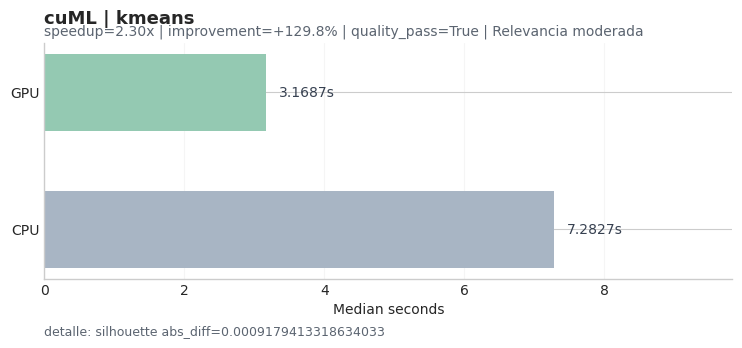

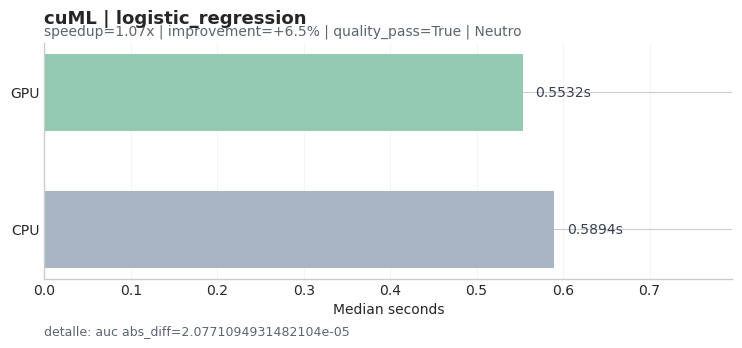

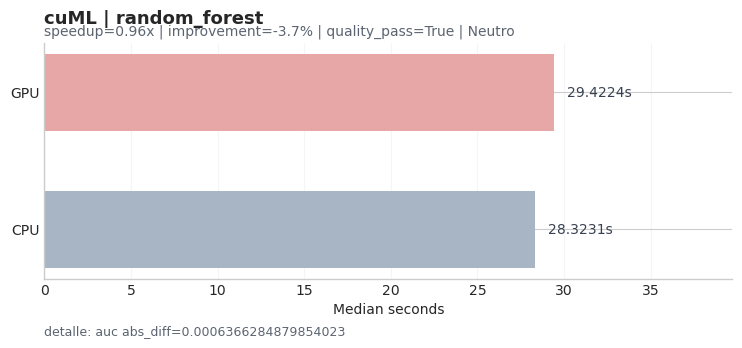

cuML conclusions: median speedup=1.07x, best=kmeans (2.30x), worst=random_forest (0.96x), quality_pass_rate=1.00
- kmeans: 2.30x (+129.8%), Relevancia moderada
- logistic_regression: 1.07x (+6.5%), Neutro
- random_forest: 0.96x (-3.7%), Neutro


In [32]:
from sklearn.cluster import KMeans as SKKMeans
from sklearn.ensemble import RandomForestClassifier as SKRF
from sklearn.linear_model import LogisticRegression as SKLR
from sklearn.metrics import roc_auc_score, silhouette_score
from sklearn.preprocessing import StandardScaler

np.random.seed(int(CONFIG["seed"]))

train = pd.read_parquet(TRAIN_FE)
test = pd.read_parquet(TEST_FE)

num = [
    "loan_amnt", "int_rate", "installment", "annual_inc", "dti", "loan_to_income", "installment_burden",
    "rev_utilization", "revol_bal_to_income", "open_acc_ratio", "fico_score", "credit_age_years", "emp_length_num",
    "open_acc", "total_acc", "revol_bal", "pub_rec", "inq_last_6mths", "mort_acc", "delinq_severity", "delinq_recency",
    "il_ratio", "high_util_pct", "log_annual_inc", "log_revol_bal", "loan_to_income_sq", "fico_x_dti",
]
feat = [c for c in num if c in train.columns and c in test.columns]
if not feat:
    raise RuntimeError("No overlapping numeric features found for cuML benchmark")

train = train.sample(n=min(int(CONFIG["cuml_train_sample"]), len(train)), random_state=int(CONFIG["seed"])).reset_index(drop=True)
test = test.sample(n=min(int(CONFIG["cuml_test_sample"]), len(test)), random_state=int(CONFIG["seed"])).reset_index(drop=True)

Xtr = train[feat].apply(pd.to_numeric, errors="coerce").fillna(0.0).astype(np.float32)
Xte = test[feat].apply(pd.to_numeric, errors="coerce").fillna(0.0).astype(np.float32)
ytr = train["default_flag"].astype(np.int32)
yte = test["default_flag"].astype(np.int32)

sc = StandardScaler()
Xtr_s = sc.fit_transform(Xtr).astype(np.float32)
Xte_s = sc.transform(Xte).astype(np.float32)


res: list[dict[str, Any]] = []


def push_result(task: str, backend: str, fit_times: list[float], pred_times: list[float], metric: str, values: list[float]) -> None:
    st_fit = stats_from(fit_times)
    st_pred = stats_from(pred_times)
    arr = np.asarray(values, dtype=np.float64)
    res.append({
        "task": task,
        "backend": backend,
        "fit_seconds": st_fit["median_seconds"],
        "fit_iqr_seconds": st_fit["iqr_seconds"],
        "predict_seconds": st_pred["median_seconds"],
        "predict_iqr_seconds": st_pred["iqr_seconds"],
        "metric": metric,
        "metric_value": float(np.median(arr)) if arr.size else np.nan,
        "metric_std": float(np.std(arr)) if arr.size else np.nan,
        "n_runs": int(arr.size),
    })


# CPU logistic regression
fit_times: list[float] = []
pred_times: list[float] = []
metrics: list[float] = []
for _ in range(int(CONFIG["cuml_repeats_light"])):
    s = time.perf_counter()
    mdl = SKLR(max_iter=600, solver="lbfgs")
    mdl.fit(Xtr_s, ytr)
    fit_times.append(time.perf_counter() - s)

    s = time.perf_counter()
    proba = mdl.predict_proba(Xte_s)[:, 1]
    pred_times.append(time.perf_counter() - s)
    metrics.append(float(roc_auc_score(yte, proba)))
push_result("logistic_regression", "sklearn_cpu", fit_times, pred_times, "auc", metrics)


# CPU random forest
fit_times = []
pred_times = []
metrics = []
for _ in range(int(CONFIG["cuml_repeats_heavy"])):
    s = time.perf_counter()
    mdl = SKRF(n_estimators=250, max_depth=12, random_state=int(CONFIG["seed"]), n_jobs=-1)
    mdl.fit(Xtr, ytr)
    fit_times.append(time.perf_counter() - s)

    s = time.perf_counter()
    proba = mdl.predict_proba(Xte)[:, 1]
    pred_times.append(time.perf_counter() - s)
    metrics.append(float(roc_auc_score(yte, proba)))
push_result("random_forest", "sklearn_cpu", fit_times, pred_times, "auc", metrics)


# CPU KMeans
Xk = Xtr_s[: min(150_000, len(Xtr_s))]
fit_times = []
pred_times = []
metrics = []
for _ in range(int(CONFIG["cuml_repeats_light"])):
    s = time.perf_counter()
    labels = SKKMeans(n_clusters=7, n_init=10, random_state=int(CONFIG["seed"])).fit_predict(Xk)
    fit_times.append(time.perf_counter() - s)
    pred_times.append(0.0)
    n_sil = min(30_000, len(Xk))
    metrics.append(float(silhouette_score(Xk[:n_sil], labels[:n_sil])))
push_result("kmeans", "sklearn_cpu", fit_times, pred_times, "silhouette", metrics)


# GPU block
if all(importlib.util.find_spec(p) is not None for p in ["cuml", "cudf", "cupy"]):
    try:
        import cupy as cp
        import cudf
        from cuml.cluster import KMeans as CUKMeans
        from cuml.ensemble import RandomForestClassifier as CURF
        from cuml.linear_model import LogisticRegression as CULR

        def sync() -> None:
            cp.cuda.Stream.null.synchronize()

        def as_numpy(x: Any) -> np.ndarray:
            if isinstance(x, np.ndarray):
                return x
            if isinstance(x, cp.ndarray):
                return cp.asnumpy(x)
            if hasattr(x, "to_numpy"):
                return x.to_numpy()
            if hasattr(x, "values_host"):
                return x.values_host
            return np.asarray(x)

        Xtrg_s = cudf.DataFrame(Xtr_s)
        Xteg_s = cudf.DataFrame(Xte_s)
        ytrg = cudf.Series(ytr.to_numpy())

        # GPU logistic regression
        fit_times = []
        pred_times = []
        metrics = []
        for _ in range(int(CONFIG["cuml_repeats_light"])):
            s = time.perf_counter()
            mdl = CULR(max_iter=600, linesearch_max_iter=100, output_type="numpy")
            mdl.fit(Xtrg_s, ytrg)
            sync()
            fit_times.append(time.perf_counter() - s)

            s = time.perf_counter()
            proba = mdl.predict_proba(Xteg_s)
            sync()
            pred_times.append(time.perf_counter() - s)

            proba = as_numpy(proba)
            proba = proba[:, 1] if proba.ndim == 2 else proba
            metrics.append(float(roc_auc_score(yte, proba)))
        push_result("logistic_regression", "cuml_gpu", fit_times, pred_times, "auc", metrics)

        # GPU random forest
        Xtrg = cudf.DataFrame(Xtr)
        Xteg = cudf.DataFrame(Xte)

        fit_times = []
        pred_times = []
        metrics = []
        for _ in range(int(CONFIG["cuml_repeats_heavy"])):
            s = time.perf_counter()
            mdl = CURF(n_estimators=250, max_depth=12, random_state=int(CONFIG["seed"]), output_type="numpy")
            mdl.fit(Xtrg, ytrg)
            sync()
            fit_times.append(time.perf_counter() - s)

            s = time.perf_counter()
            proba = mdl.predict_proba(Xteg)
            sync()
            pred_times.append(time.perf_counter() - s)

            proba = as_numpy(proba)
            proba = proba[:, 1] if proba.ndim == 2 else proba
            metrics.append(float(roc_auc_score(yte, proba)))
        push_result("random_forest", "cuml_gpu", fit_times, pred_times, "auc", metrics)

        # GPU KMeans
        Xkg = cudf.DataFrame(Xk)
        fit_times = []
        pred_times = []
        metrics = []
        for _ in range(int(CONFIG["cuml_repeats_light"])):
            s = time.perf_counter()
            labels = CUKMeans(n_clusters=7, n_init=10, random_state=int(CONFIG["seed"]), output_type="numpy").fit_predict(Xkg)
            sync()
            fit_times.append(time.perf_counter() - s)
            pred_times.append(0.0)

            labels = as_numpy(labels)
            n_sil = min(30_000, len(Xk))
            metrics.append(float(silhouette_score(Xk[:n_sil], labels[:n_sil])))
        push_result("kmeans", "cuml_gpu", fit_times, pred_times, "silhouette", metrics)

    except Exception as exc:
        print("cuML GPU block failed:", repr(exc))
        traceback.print_exc(limit=2)
else:
    print("cuML/cuDF/cuPy not available -> CPU baseline only")


cuml_df = pd.DataFrame(res)
for t in cuml_df["task"].unique():
    cpu = cuml_df[(cuml_df["task"] == t) & (cuml_df["backend"] == "sklearn_cpu")]
    if len(cpu) == 1:
        b = float(cpu.iloc[0]["fit_seconds"])
        mask = cuml_df["task"] == t
        cuml_df.loc[mask, "fit_speedup_vs_cpu"] = np.where(
            cuml_df.loc[mask, "backend"] == "sklearn_cpu",
            np.nan,
            b / cuml_df.loc[mask, "fit_seconds"],
        )


tols = {
    "logistic_regression": 0.010,
    "random_forest": 0.025,
    "kmeans": 0.040,
}
qrows = []
for task in ["logistic_regression", "random_forest", "kmeans"]:
    cpu = cuml_df[(cuml_df["task"] == task) & (cuml_df["backend"] == "sklearn_cpu")]
    gpu = cuml_df[(cuml_df["task"] == task) & (cuml_df["backend"] == "cuml_gpu")]
    if len(cpu) == 1 and len(gpu) == 1:
        cpu_m = float(cpu.iloc[0]["metric_value"])
        gpu_m = float(gpu.iloc[0]["metric_value"])
        abs_diff = abs(cpu_m - gpu_m)
        qrows.append({
            "task": task,
            "metric": cpu.iloc[0]["metric"],
            "cpu_metric": cpu_m,
            "gpu_metric": gpu_m,
            "abs_diff": abs_diff,
            "rel_diff": rel_err(cpu_m, gpu_m),
            "tolerance": tols.get(task, 0.05),
            "quality_pass": abs_diff <= tols.get(task, 0.05),
        })

cuml_quality_df = pd.DataFrame(qrows)

display(cuml_df.sort_values(["task", "backend"]))
if len(cuml_quality_df):
    display(cuml_quality_df.sort_values("task"))

maybe_save(cuml_df, "cuml_benchmark.csv")
if len(cuml_quality_df):
    maybe_save(cuml_quality_df, "cuml_quality_checks.csv")

# Direct CPU vs GPU view for cuML section
cuml_pair_rows: list[dict[str, Any]] = []
for task in sorted(cuml_df["task"].dropna().unique()):
    cpu = cuml_df[(cuml_df["task"] == task) & (cuml_df["backend"] == "sklearn_cpu")]
    gpu = cuml_df[(cuml_df["task"] == task) & (cuml_df["backend"] == "cuml_gpu")]
    if len(cpu) == 1 and len(gpu) == 1:
        qpass = True
        note = ""
        if len(cuml_quality_df):
            q = cuml_quality_df[cuml_quality_df["task"] == task]
            if len(q) == 1:
                qpass = bool(q.iloc[0].get("quality_pass", True))
                note = f"{q.iloc[0].get('metric', '')} abs_diff={q.iloc[0].get('abs_diff', np.nan)}"
        cpu_s = float(cpu.iloc[0]["fit_seconds"])
        gpu_s = float(gpu.iloc[0]["fit_seconds"])
        cuml_pair_rows.append({
            "section": "cuml",
            "method": str(task),
            "cpu_backend": "sklearn_cpu",
            "gpu_backend": "cuml_gpu",
            "cpu_seconds": cpu_s,
            "gpu_seconds": gpu_s,
            "speedup_x": cpu_s / max(gpu_s, 1e-12),
            "quality_pass": qpass,
            "note": note,
        })

cuml_direct_df = finalize_direct_df(pd.DataFrame(cuml_pair_rows), "cuml")
if len(cuml_direct_df):
    display(cuml_direct_df)
    plot_method_pairs(cuml_direct_df, "cuML")
    print_section_conclusions(cuml_direct_df, "cuML")
    maybe_save(cuml_direct_df, "direct_cpu_vs_gpu_cuml.csv")


## 3) cuGraph benchmark (native + networkx backend dispatch)

Graph is built from loan-to-attribute bipartite links (`grade`, `purpose`, `sub_grade`, `verification_status`).

Compared paths:
- Native NetworkX CPU
- Native cuGraph GPU
- NetworkX dispatch with `backend="cugraph"` (if `nx-cugraph` is available)

Additional checks:
- Connected components parity
- PageRank sum sanity (near 1.0)
- Convergence tracking for cuGraph PageRank
- Dedicated CPU-vs-GPU chart per method in this same section


,task,backend,seconds,seconds_iqr,metric,metric_value,converged_rate,speedup_vs_cpu
4,connected_components,cugraph_gpu,0.011947,0.006185,n_components,1.0,NaN,1.282365
1,connected_components,networkx_cpu,0.015320,0.003125,n_components,1.0,NaN,NaN
6,connected_components,networkx_cugraph_backend,0.037650,0.026847,n_components,1.0,NaN,0.406909
3,graph_build,cugraph_gpu,0.124091,0.050838,nodes,30059.0,NaN,1.074478
0,graph_build,networkx_cpu,0.133333,0.678730,nodes,30059.0,NaN,NaN
5,pagerank,cugraph_gpu,0.036150,0.001446,sum_pagerank,1.0,1.0,10.473903
2,pagerank,networkx_cpu,0.378633,0.109661,sum_pagerank,1.0,1.0,NaN
7,pagerank,networkx_cugraph_backend,0.153502,0.042422,sum_pagerank,1.0,1.0,2.466632


,task,backend,cpu_metric,other_metric,abs_diff,quality_pass
0,connected_components,cugraph_gpu,1.0,1.0,0.000000e+00,True
1,connected_components,networkx_cugraph_backend,1.0,1.0,0.000000e+00,True
3,pagerank,cugraph_gpu,1.0,1.0,5.960464e-08,True
2,pagerank,networkx_cpu,1.0,1.0,9.658940e-15,True
4,pagerank,networkx_cugraph_backend,1.0,1.0,7.549517e-15,True


,section,method,cpu_backend,gpu_backend,cpu_seconds,gpu_seconds,speedup_x,improvement_pct,seconds_saved,quality_pass,relevance,note
0,cugraph,connected_components,networkx_cpu,cugraph_gpu,0.015320,0.011947,1.282365,28.236468,0.003373,True,Relevancia baja,metric_abs_diff=0.0
1,cugraph,graph_build,networkx_cpu,cugraph_gpu,0.133333,0.124091,1.074478,7.447772,0.009242,True,Neutro,
2,cugraph,pagerank,networkx_cpu,cugraph_gpu,0.378633,0.036150,10.473903,947.390330,0.342482,True,Alta relevancia,metric_abs_diff=5.960464477539063e-08 converge...


cuGraph: gráficos CPU vs GPU por método


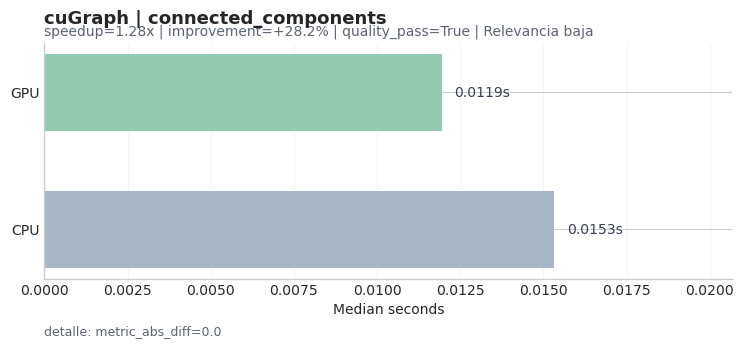

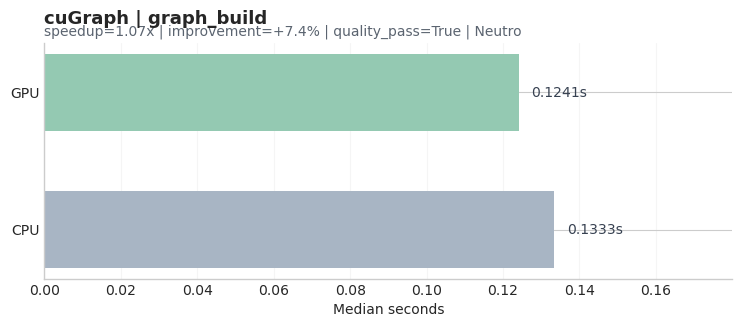

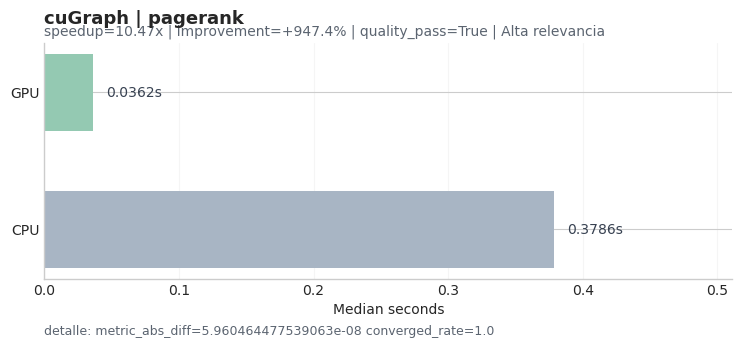

cuGraph conclusions: median speedup=1.28x, best=pagerank (10.47x), worst=graph_build (1.07x), quality_pass_rate=1.00
- pagerank: 10.47x (+947.4%), Alta relevancia
- connected_components: 1.28x (+28.2%), Relevancia baja
- graph_build: 1.07x (+7.4%), Neutro


In [33]:
import networkx as nx

np.random.seed(int(CONFIG["seed"]))

if hasattr(nx, "config") and hasattr(nx.config, "warnings_to_ignore"):
    try:
        nx.config.warnings_to_ignore.add("cache")
    except Exception:
        pass


g = pd.read_parquet(TRAIN, columns=["id", "grade", "purpose", "sub_grade", "verification_status"]).dropna(subset=["id"]).copy()
g = g.sample(n=min(int(CONFIG["cugraph_sample_rows"]), len(g)), random_state=int(CONFIG["seed"]))
g["id"] = pd.to_numeric(g["id"], errors="coerce")
g = g.dropna(subset=["id"])
g["id"] = g["id"].astype(np.int64)

for col in ["grade", "purpose", "sub_grade", "verification_status"]:
    g[col] = g[col].fillna("unknown").astype(str)

g["loan"] = "L_" + g["id"].astype(str)

edges = pd.concat([
    g[["loan", "grade"]].rename(columns={"loan": "src", "grade": "dst"}).assign(dst=lambda x: "G_" + x["dst"]),
    g[["loan", "purpose"]].rename(columns={"loan": "src", "purpose": "dst"}).assign(dst=lambda x: "P_" + x["dst"]),
    g[["loan", "sub_grade"]].rename(columns={"loan": "src", "sub_grade": "dst"}).assign(dst=lambda x: "SG_" + x["dst"]),
    g[["loan", "verification_status"]].rename(columns={"loan": "src", "verification_status": "dst"}).assign(dst=lambda x: "V_" + x["dst"]),
], ignore_index=True)

nodes = pd.Index(pd.concat([edges["src"], edges["dst"]], ignore_index=True).unique())
node2id = pd.Series(np.arange(len(nodes), dtype=np.int64), index=nodes)

E = pd.DataFrame({
    "src": edges["src"].map(node2id).astype(np.int32),
    "dst": edges["dst"].map(node2id).astype(np.int32),
})

R = int(CONFIG["cugraph_repeats"])
cres: list[dict[str, Any]] = []


def add_row(task: str, backend: str, times: list[float], metric: str, metric_value: float, **extra: Any) -> None:
    st = stats_from(times)
    row: dict[str, Any] = {
        "task": task,
        "backend": backend,
        "seconds": st["median_seconds"],
        "seconds_iqr": st["iqr_seconds"],
        "metric": metric,
        "metric_value": float(metric_value),
    }
    row.update(extra)
    cres.append(row)


# NetworkX CPU baseline
build_times: list[float] = []
G_cpu = None
for _ in range(R):
    s = time.perf_counter()
    G_cpu = nx.from_pandas_edgelist(E, source="src", target="dst", create_using=nx.Graph())
    build_times.append(time.perf_counter() - s)

cc_times: list[float] = []
cc_val = None
for _ in range(R):
    s = time.perf_counter()
    cc_val = nx.number_connected_components(G_cpu)
    cc_times.append(time.perf_counter() - s)

pr_times: list[float] = []
pr_sum = None
for _ in range(R):
    s = time.perf_counter()
    pr = nx.pagerank(G_cpu, alpha=0.85, max_iter=200, tol=1e-6)
    pr_times.append(time.perf_counter() - s)
    pr_sum = float(sum(pr.values()))

add_row("graph_build", "networkx_cpu", build_times, "nodes", float(G_cpu.number_of_nodes()))
add_row("connected_components", "networkx_cpu", cc_times, "n_components", float(cc_val))
add_row("pagerank", "networkx_cpu", pr_times, "sum_pagerank", float(pr_sum), converged_rate=1.0)


# Native cuGraph
if all(importlib.util.find_spec(p) is not None for p in ["cugraph", "cudf", "cupy"]):
    try:
        import cupy as cp
        import cudf
        import cugraph

        def sync() -> None:
            cp.cuda.Stream.null.synchronize()

        Eg = cudf.DataFrame(E)

        build_times = []
        G_gpu = None
        for _ in range(R):
            s = time.perf_counter()
            G_gpu = cugraph.Graph(directed=False)
            G_gpu.from_cudf_edgelist(Eg, source="src", destination="dst", renumber=False, store_transposed=True)
            sync()
            build_times.append(time.perf_counter() - s)

        cc_times = []
        ncc = None
        for _ in range(R):
            s = time.perf_counter()
            ccg = cugraph.connected_components(G_gpu)
            sync()
            cc_times.append(time.perf_counter() - s)
            lcol = "labels" if "labels" in ccg.columns else ccg.columns[-1]
            ncc = int(ccg[lcol].nunique())

        pr_times = []
        pr_sum = None
        converged_flags: list[bool] = []
        for _ in range(R):
            s = time.perf_counter()
            out = cugraph.pagerank(
                G_gpu,
                alpha=0.85,
                max_iter=200,
                tol=1e-6,
                fail_on_nonconvergence=False,
            )
            sync()
            pr_times.append(time.perf_counter() - s)

            if isinstance(out, tuple):
                prg, converged = out
                converged_flags.append(bool(converged))
            else:
                prg = out
                converged_flags.append(True)
            pr_sum = float(prg["pagerank"].sum())

        add_row("graph_build", "cugraph_gpu", build_times, "nodes", float(G_gpu.number_of_vertices()))
        add_row("connected_components", "cugraph_gpu", cc_times, "n_components", float(ncc))
        add_row(
            "pagerank",
            "cugraph_gpu",
            pr_times,
            "sum_pagerank",
            float(pr_sum),
            converged_rate=float(np.mean(converged_flags)),
        )

    except Exception as exc:
        print("cuGraph GPU block failed:", repr(exc))
        traceback.print_exc(limit=2)
else:
    print("cugraph/cudf/cupy not available -> CPU only")


# NetworkX backend dispatch (nx-cugraph)
if importlib.util.find_spec("nx_cugraph") is not None:
    try:
        cc_times = []
        cc_val_backend = None
        for _ in range(R):
            s = time.perf_counter()
            cc_val_backend = sum(1 for _ in nx.connected_components(G_cpu, backend="cugraph"))
            cc_times.append(time.perf_counter() - s)

        pr_times = []
        pr_sum_backend = None
        for _ in range(R):
            s = time.perf_counter()
            pr_backend = nx.pagerank(G_cpu, alpha=0.85, max_iter=200, tol=1e-6, backend="cugraph")
            pr_times.append(time.perf_counter() - s)
            pr_sum_backend = float(sum(pr_backend.values()))

        add_row("connected_components", "networkx_cugraph_backend", cc_times, "n_components", float(cc_val_backend))
        add_row("pagerank", "networkx_cugraph_backend", pr_times, "sum_pagerank", float(pr_sum_backend), converged_rate=1.0)
    except Exception as exc:
        print("nx-cugraph backend block failed:", repr(exc))
        traceback.print_exc(limit=2)
else:
    print("nx_cugraph not available -> skipping NetworkX backend dispatch")


cugraph_df = pd.DataFrame(cres)
for t in cugraph_df["task"].unique():
    cpu = cugraph_df[(cugraph_df["task"] == t) & (cugraph_df["backend"] == "networkx_cpu")]
    if len(cpu) == 1:
        b = float(cpu.iloc[0]["seconds"])
        mask = cugraph_df["task"] == t
        cugraph_df.loc[mask, "speedup_vs_cpu"] = np.where(
            cugraph_df.loc[mask, "backend"] == "networkx_cpu",
            np.nan,
            b / cugraph_df.loc[mask, "seconds"],
        )


qrows = []
cpu_cc = cugraph_df[(cugraph_df["task"] == "connected_components") & (cugraph_df["backend"] == "networkx_cpu")]
if len(cpu_cc) == 1:
    cc_base = float(cpu_cc.iloc[0]["metric_value"])
    for _, r in cugraph_df[cugraph_df["task"] == "connected_components"].iterrows():
        if r["backend"] == "networkx_cpu":
            continue
        qrows.append({
            "task": "connected_components",
            "backend": r["backend"],
            "cpu_metric": cc_base,
            "other_metric": float(r["metric_value"]),
            "abs_diff": abs(cc_base - float(r["metric_value"])),
            "quality_pass": abs(cc_base - float(r["metric_value"])) <= 0.0,
        })

for _, r in cugraph_df[cugraph_df["task"] == "pagerank"].iterrows():
    qrows.append({
        "task": "pagerank",
        "backend": r["backend"],
        "cpu_metric": 1.0,
        "other_metric": float(r["metric_value"]),
        "abs_diff": abs(1.0 - float(r["metric_value"])),
        "quality_pass": abs(1.0 - float(r["metric_value"])) <= 0.02,
    })

cugraph_quality_df = pd.DataFrame(qrows)

display(cugraph_df.sort_values(["task", "backend"]))
if len(cugraph_quality_df):
    display(cugraph_quality_df.sort_values(["task", "backend"]))

maybe_save(cugraph_df, "cugraph_benchmark.csv")
if len(cugraph_quality_df):
    maybe_save(cugraph_quality_df, "cugraph_quality_checks.csv")

# Direct CPU vs GPU view for cuGraph section
cugraph_pair_rows: list[dict[str, Any]] = []
for task in sorted(cugraph_df["task"].dropna().unique()):
    cpu = cugraph_df[(cugraph_df["task"] == task) & (cugraph_df["backend"] == "networkx_cpu")]
    gpu = cugraph_df[(cugraph_df["task"] == task) & (cugraph_df["backend"] == "cugraph_gpu")]
    if len(cpu) == 1 and len(gpu) == 1:
        qpass = True
        note = ""
        if len(cugraph_quality_df):
            q = cugraph_quality_df[(cugraph_quality_df["task"] == task) & (cugraph_quality_df["backend"] == "cugraph_gpu")]
            if len(q) == 1:
                qpass = bool(q.iloc[0].get("quality_pass", True))
                note = f"metric_abs_diff={q.iloc[0].get('abs_diff', np.nan)}"
        if task == "pagerank" and "converged_rate" in gpu.columns:
            note = (note + " " + f"converged_rate={gpu.iloc[0].get('converged_rate', np.nan)}").strip()

        cpu_s = float(cpu.iloc[0]["seconds"])
        gpu_s = float(gpu.iloc[0]["seconds"])
        cugraph_pair_rows.append({
            "section": "cugraph",
            "method": str(task),
            "cpu_backend": "networkx_cpu",
            "gpu_backend": "cugraph_gpu",
            "cpu_seconds": cpu_s,
            "gpu_seconds": gpu_s,
            "speedup_x": cpu_s / max(gpu_s, 1e-12),
            "quality_pass": qpass,
            "note": note,
        })

cugraph_direct_df = finalize_direct_df(pd.DataFrame(cugraph_pair_rows), "cugraph")
if len(cugraph_direct_df):
    display(cugraph_direct_df)
    plot_method_pairs(cugraph_direct_df, "cuGraph")
    print_section_conclusions(cugraph_direct_df, "cuGraph")
    maybe_save(cugraph_direct_df, "direct_cpu_vs_gpu_cugraph.csv")


## 4) cuOpt benchmark (LP) + API smoke test

Formulation:
- Continuous LP portfolio selection with budget, risk, and concentration constraints.
- CPU baseline: `scipy.optimize.linprog(method="highs")`
- GPU path: cuOpt LP via `linear_programming.DataModel` + `Solve`

Also included:
- Small `Problem` API smoke test (`addVariable`, `addConstraint`, `setObjective`, `solve`)
- Dedicated CPU-vs-GPU chart for LP in this same section


cuOpt version: 25.12.0, git hash: , host arch: x86_64, device archs: 75-real,80-real,86-real,90a-real,100f-real,120a-real,120
CPU: AMD Ryzen 5 5600X 6-Core Processor, threads (physical/logical): 5/10, RAM: 13.56 GiB
CUDA 13.1, device: NVIDIA GeForce RTX 3080 (ID 0), VRAM: 10.00 GiB
CUDA device UUID: 7a293451-0821-ffffffe1ffffffc2-12fff

Solving a problem with 2 constraints, 2 variables (0 integers), and 4 nonzeros
Problem scaling:
Objective coefficents range:          [1e+00, 1e+00]
Constraint matrix coefficients range: [1e+00, 1e+00]
Constraint rhs / bounds range:        [0e+00, 1e+01]
Variable bounds range:                [0e+00, 1e+01]

Third-party presolve is disabled, skipping
Objective offset -0.000000 scaling_factor -1.000000
Running concurrent

Dual simplex finished in 0.00 seconds, total time 0.00
Barrier finished in 0.01 seconds
   Iter    Primal Obj.      Dual Obj.    Gap        Primal Res.  Dual Res.   Time
      0 -0.00000000e+00 -0.00000000e+00  0.00e+00   0.00e+00     1.

,task,backend,seconds,seconds_iqr,status,objective,n_variables,n_runs,speedup_vs_cpu_lp
3,api_smoke_problem_class,cuopt_gpu,0.035255,NaN,Optimal,1.000000e+01,2,1,NaN
2,portfolio_lp,cuopt_gpu,0.101438,0.029830,Optimal,3.643971e+06,18000,3,0.585697
0,portfolio_lp,scipy_highs_cpu,0.059412,0.004727,0,3.643971e+06,18000,3,NaN
1,portfolio_milp_reference,scipy_milp_cpu,0.084495,NaN,0,2.275965e+06,3000,1,NaN


,check,cpu_objective,gpu_objective,rel_diff,tolerance,quality_pass
0,lp_objective_parity,3.643971e+06,3.643971e+06,1.571811e-14,0.000100,True
1,problem_api_smoke,1.000000e+01,1.000000e+01,0.000000e+00,0.000001,True


,section,method,cpu_backend,gpu_backend,cpu_seconds,gpu_seconds,speedup_x,improvement_pct,seconds_saved,quality_pass,relevance,note
0,cuopt,portfolio_lp,scipy_highs_cpu,cuopt_gpu,0.059412,0.101438,0.585697,-41.430258,-0.042026,True,No relevante (CPU mejor),lp_rel_diff=1.5718111138395294e-14


cuOpt: gráficos CPU vs GPU por método


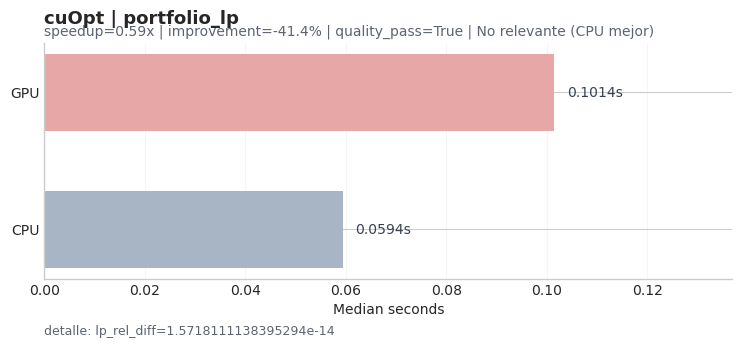

cuOpt conclusions: median speedup=0.59x, best=portfolio_lp (0.59x), worst=portfolio_lp (0.59x), quality_pass_rate=1.00
- portfolio_lp: 0.59x (-41.4%), No relevante (CPU mejor)


In [34]:
from scipy.optimize import Bounds, LinearConstraint, linprog, milp
from scipy.sparse import csr_matrix

np.random.seed(int(CONFIG["seed"]))

train_grade = pd.read_parquet(TRAIN, columns=["grade", "default_flag"]).dropna(subset=["grade"])
grade_pd = train_grade.groupby("grade")["default_flag"].mean()

df = pd.read_parquet(TEST, columns=["loan_amnt", "int_rate", "grade", "purpose", "default_flag"]).dropna(
    subset=["loan_amnt", "int_rate", "grade"]
).copy()
df = df.sample(n=min(int(CONFIG["cuopt_sample_rows"]), len(df)), random_state=int(CONFIG["seed"])).reset_index(drop=True)

df["loan_amnt"] = pd.to_numeric(df["loan_amnt"], errors="coerce").fillna(0.0)
df["int_rate"] = pd.to_numeric(df["int_rate"].astype(str).str.rstrip("%"), errors="coerce").fillna(0.0)
df["pd"] = df["grade"].map(grade_pd).fillna(float(grade_pd.mean())).clip(0.001, 0.99)

loan = df["loan_amnt"].to_numpy(np.float64)
ir = (df["int_rate"] / 100.0).to_numpy(np.float64)
pd_proxy = df["pd"].to_numpy(np.float64)
obj = loan * (ir - 0.45 * pd_proxy)

budget = float(loan.sum() * 0.20)
purpose_vals = df["purpose"].astype(str).to_numpy()
rows = [loan, loan * pd_proxy]
rhs = [budget, 0.10 * budget]
for p in df["purpose"].astype(str).value_counts().head(2).index.tolist():
    rows.append(np.where(purpose_vals == p, loan, 0.0))
    rhs.append(0.35 * budget)

A = np.vstack(rows).astype(np.float64)
b = np.array(rhs, dtype=np.float64)

opt_res: list[dict[str, Any]] = []


# CPU LP (repeat)
lp_times: list[float] = []
lp_objs: list[float] = []
lp_status: list[int] = []
for _ in range(int(CONFIG["cuopt_repeats"])):
    s = time.perf_counter()
    lp_cpu = linprog(c=-obj, A_ub=A, b_ub=b, bounds=(0, 1), method="highs")
    lp_times.append(time.perf_counter() - s)
    lp_status.append(int(lp_cpu.status))
    lp_objs.append(float(-lp_cpu.fun) if lp_cpu.success else np.nan)

st = stats_from(lp_times)
opt_res.append({
    "task": "portfolio_lp",
    "backend": "scipy_highs_cpu",
    "seconds": st["median_seconds"],
    "seconds_iqr": st["iqr_seconds"],
    "status": str(lp_status[-1]),
    "objective": float(np.nanmedian(np.asarray(lp_objs, dtype=np.float64))),
    "n_variables": int(len(obj)),
    "n_runs": int(len(lp_times)),
})


# CPU MILP reference (single-run, smaller N)
n_milp = min(3000, len(obj))
Ac = A[:, :n_milp]
cc = -obj[:n_milp]
lc = LinearConstraint(Ac, -np.inf * np.ones(Ac.shape[0]), b)
bb = Bounds(lb=np.zeros(n_milp), ub=np.ones(n_milp))
ig = np.ones(n_milp, dtype=int)

s = time.perf_counter()
mi = milp(c=cc, integrality=ig, bounds=bb, constraints=lc, options={"time_limit": 120})
t_mi = time.perf_counter() - s

opt_res.append({
    "task": "portfolio_milp_reference",
    "backend": "scipy_milp_cpu",
    "seconds": float(t_mi),
    "seconds_iqr": np.nan,
    "status": str(mi.status),
    "objective": float(-mi.fun) if mi.success else np.nan,
    "n_variables": int(n_milp),
    "n_runs": 1,
})


# cuOpt LP via DataModel + Solve
if importlib.util.find_spec("cuopt") is not None:
    try:
        from cuopt import linear_programming as lp

        gpu_times: list[float] = []
        gpu_obj: list[float] = []
        gpu_reason: list[str] = []

        A_csr = csr_matrix(A)
        row_types = np.array(["L"] * A.shape[0])
        lb = np.zeros(A.shape[1], dtype=np.float64)
        ub = np.ones(A.shape[1], dtype=np.float64)

        for _ in range(int(CONFIG["cuopt_repeats"])):
            dm = lp.DataModel()
            dm.set_csr_constraint_matrix(
                A_csr.data.astype(np.float64),
                A_csr.indices.astype(np.int32),
                A_csr.indptr.astype(np.int32),
            )
            dm.set_constraint_bounds(b)
            dm.set_row_types(row_types)
            dm.set_objective_coefficients(obj.astype(np.float64))
            dm.set_maximize(True)
            dm.set_variable_lower_bounds(lb)
            dm.set_variable_upper_bounds(ub)

            settings = lp.SolverSettings()
            try:
                settings.set_parameter("log_to_console", False)
            except Exception:
                pass
            settings.set_parameter("time_limit", 120)

            s = time.perf_counter()
            sol = lp.Solve(dm, settings)
            gpu_times.append(time.perf_counter() - s)

            reason = str(sol.get_termination_reason())
            gpu_reason.append(reason)
            if "Optimal" in reason:
                gpu_obj.append(float(sol.get_primal_objective()))
            else:
                gpu_obj.append(np.nan)

        st_gpu = stats_from(gpu_times)
        opt_res.append({
            "task": "portfolio_lp",
            "backend": "cuopt_gpu",
            "seconds": st_gpu["median_seconds"],
            "seconds_iqr": st_gpu["iqr_seconds"],
            "status": gpu_reason[-1],
            "objective": float(np.nanmedian(np.asarray(gpu_obj, dtype=np.float64))),
            "n_variables": int(len(obj)),
            "n_runs": int(len(gpu_times)),
        })

        # Problem API smoke test (new API path)
        smoke_status = "error"
        smoke_obj = np.nan
        smoke_t0 = time.perf_counter()
        try:
            from cuopt.linear_programming.problem import CONTINUOUS, MAXIMIZE, Problem

            p = Problem("api_smoke")
            x = p.addVariable(lb=0.0, ub=10.0, vtype=CONTINUOUS, name="x")
            y = p.addVariable(lb=0.0, ub=10.0, vtype=CONTINUOUS, name="y")
            p.addConstraint(x + y <= 10.0)
            p.addConstraint(x - y >= 0.0)
            p.setObjective(x + y, sense=MAXIMIZE)
            p.solve()
            smoke_status = str(getattr(p.Status, "name", p.Status))
            smoke_obj = float(p.ObjValue)
        except Exception as exc:
            smoke_status = f"error: {exc}"
        smoke_t = time.perf_counter() - smoke_t0

        opt_res.append({
            "task": "api_smoke_problem_class",
            "backend": "cuopt_gpu",
            "seconds": float(smoke_t),
            "seconds_iqr": np.nan,
            "status": smoke_status,
            "objective": smoke_obj,
            "n_variables": 2,
            "n_runs": 1,
        })

    except Exception as exc:
        opt_res.append({
            "task": "portfolio_lp",
            "backend": "cuopt_gpu",
            "seconds": np.nan,
            "seconds_iqr": np.nan,
            "status": f"error: {exc}",
            "objective": np.nan,
            "n_variables": int(len(obj)),
            "n_runs": 0,
        })
        traceback.print_exc(limit=2)
else:
    print("cuopt not available -> CPU only")


cuopt_df = pd.DataFrame(opt_res)
cpu = cuopt_df[(cuopt_df["task"] == "portfolio_lp") & (cuopt_df["backend"] == "scipy_highs_cpu")]
if len(cpu) == 1:
    btime = float(cpu.iloc[0]["seconds"])
    mask = cuopt_df["task"] == "portfolio_lp"
    cuopt_df.loc[mask, "speedup_vs_cpu_lp"] = np.where(
        cuopt_df.loc[mask, "backend"] == "scipy_highs_cpu",
        np.nan,
        btime / cuopt_df.loc[mask, "seconds"],
    )

qrows = []
gpu_lp = cuopt_df[(cuopt_df["task"] == "portfolio_lp") & (cuopt_df["backend"] == "cuopt_gpu")]
if len(cpu) == 1 and len(gpu_lp) == 1:
    cpu_obj = float(cpu.iloc[0]["objective"])
    gpu_obj = float(gpu_lp.iloc[0]["objective"])
    ok = np.isfinite(cpu_obj) and np.isfinite(gpu_obj)
    qrows.append({
        "check": "lp_objective_parity",
        "cpu_objective": cpu_obj,
        "gpu_objective": gpu_obj,
        "rel_diff": rel_err(cpu_obj, gpu_obj) if ok else np.nan,
        "tolerance": 1e-4,
        "quality_pass": bool(ok and rel_err(cpu_obj, gpu_obj) <= 1e-4),
    })

smoke = cuopt_df[cuopt_df["task"] == "api_smoke_problem_class"]
if len(smoke) == 1:
    st = str(smoke.iloc[0]["status"])
    objv = float(smoke.iloc[0]["objective"]) if pd.notna(smoke.iloc[0]["objective"]) else np.nan
    qrows.append({
        "check": "problem_api_smoke",
        "cpu_objective": 10.0,
        "gpu_objective": objv,
        "rel_diff": rel_err(10.0, objv) if np.isfinite(objv) else np.nan,
        "tolerance": 1e-6,
        "quality_pass": ("Optimal" in st) and np.isfinite(objv) and abs(objv - 10.0) <= 1e-6,
    })

cuopt_quality_df = pd.DataFrame(qrows)

display(cuopt_df.sort_values(["task", "backend"]))
if len(cuopt_quality_df):
    display(cuopt_quality_df)

maybe_save(cuopt_df, "cuopt_benchmark.csv")
if len(cuopt_quality_df):
    maybe_save(cuopt_quality_df, "cuopt_quality_checks.csv")

# Direct CPU vs GPU view for cuOpt section
cuopt_pair_rows: list[dict[str, Any]] = []
cpu_lp = cuopt_df[(cuopt_df["task"] == "portfolio_lp") & (cuopt_df["backend"] == "scipy_highs_cpu")]
gpu_lp = cuopt_df[(cuopt_df["task"] == "portfolio_lp") & (cuopt_df["backend"] == "cuopt_gpu")]
if len(cpu_lp) == 1 and len(gpu_lp) == 1:
    qpass = True
    note = ""
    if len(cuopt_quality_df):
        q = cuopt_quality_df[cuopt_quality_df["check"] == "lp_objective_parity"]
        if len(q) == 1:
            qpass = bool(q.iloc[0].get("quality_pass", True))
            note = f"lp_rel_diff={q.iloc[0].get('rel_diff', np.nan)}"
    cpu_s = float(cpu_lp.iloc[0]["seconds"])
    gpu_s = float(gpu_lp.iloc[0]["seconds"])
    cuopt_pair_rows.append({
        "section": "cuopt",
        "method": "portfolio_lp",
        "cpu_backend": "scipy_highs_cpu",
        "gpu_backend": "cuopt_gpu",
        "cpu_seconds": cpu_s,
        "gpu_seconds": gpu_s,
        "speedup_x": cpu_s / max(gpu_s, 1e-12),
        "quality_pass": qpass,
        "note": note,
    })

cuopt_direct_df = finalize_direct_df(pd.DataFrame(cuopt_pair_rows), "cuopt")
if len(cuopt_direct_df):
    display(cuopt_direct_df)
    plot_method_pairs(cuopt_direct_df, "cuOpt")
    print_section_conclusions(cuopt_direct_df, "cuOpt")
    maybe_save(cuopt_direct_df, "direct_cpu_vs_gpu_cuopt.csv")


In [35]:
# Consolidated summary + quality gates
parts = []
for name in ["cudf_df", "cuml_df", "cugraph_df", "cuopt_df"]:
    if name in globals():
        tmp = globals()[name].copy()
        tmp["section"] = name.replace("_df", "")
        parts.append(tmp)

if parts:
    summary = pd.concat(parts, ignore_index=True, sort=False)
    display(summary)

    speed_cols = [
        c for c in [
            "speedup_vs_pandas_cpu",
            "fit_speedup_vs_cpu",
            "speedup_vs_cpu",
            "speedup_vs_cpu_lp",
        ] if c in summary.columns
    ]
    if speed_cols:
        top = summary[["section", "task", "backend", *speed_cols]].copy()
        display(top)

    maybe_save(summary, "benchmark_summary_all_sections.csv")


checks = []
for name in ["cuml_quality_df", "cugraph_quality_df", "cuopt_quality_df"]:
    if name in globals() and isinstance(globals()[name], pd.DataFrame) and len(globals()[name]):
        tmp = globals()[name].copy()
        tmp["section"] = name.replace("_quality_df", "")
        checks.append(tmp)

if checks:
    quality = pd.concat(checks, ignore_index=True, sort=False)
    display(quality)

    if "quality_pass" in quality.columns:
        failed = quality[quality["quality_pass"] == False]
        if len(failed):
            print("Quality checks with failures:", len(failed))
            display(failed)
        else:
            print("All available quality checks passed.")

    maybe_save(quality, "benchmark_quality_checks_all_sections.csv")


,command,status,returncode,stderr_tail,median_seconds,mean_seconds,std_seconds,iqr_seconds,rows_out,checksum,...,metric_std,n_runs,fit_speedup_vs_cpu,seconds,seconds_iqr,converged_rate,speedup_vs_cpu,objective,n_variables,speedup_vs_cpu_lp
0,/home/eigenlinux/miniforge3/envs/rapids/bin/py...,ok,0.0,,3.388590,3.373810,0.054722,0.072646,76.0,3.796756e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,/home/eigenlinux/miniforge3/envs/rapids/bin/py...,ok,0.0,,0.107075,0.108281,0.008799,0.013867,76.0,3.796756e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,/home/eigenlinux/miniforge3/envs/rapids/bin/py...,ok,0.0,,0.404061,0.402340,0.030466,0.057034,76.0,3.796756e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,/home/eigenlinux/miniforge3/envs/rapids/bin/py...,ok,0.0,,0.087033,0.091322,0.008371,0.006867,76.0,3.796756e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.887906e-05,2.0,1.065470,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,1.0,0.962637,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.172325e-07,2.0,2.298352,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,section,task,backend,speedup_vs_pandas_cpu,fit_speedup_vs_cpu,speedup_vs_cpu,speedup_vs_cpu_lp
0,cudf,NaN,NaN,1.000000,NaN,NaN,NaN
1,cudf,NaN,NaN,31.646893,NaN,NaN,NaN
2,cudf,NaN,NaN,8.386329,NaN,NaN,NaN
3,cudf,NaN,NaN,38.934433,NaN,NaN,NaN
4,cuml,logistic_regression,sklearn_cpu,NaN,NaN,NaN,NaN
5,cuml,random_forest,sklearn_cpu,NaN,NaN,NaN,NaN
6,cuml,kmeans,sklearn_cpu,NaN,NaN,NaN,NaN
7,cuml,logistic_regression,cuml_gpu,NaN,1.065470,NaN,NaN
8,cuml,random_forest,cuml_gpu,NaN,0.962637,NaN,NaN
9,cuml,kmeans,cuml_gpu,NaN,2.298352,NaN,NaN


,task,metric,cpu_metric,gpu_metric,abs_diff,rel_diff,tolerance,quality_pass,section,backend,other_metric,check,cpu_objective,gpu_objective
0,logistic_regression,auc,0.692313,0.692334,2.077109e-05,3.000245e-05,0.010000,True,cuml,NaN,NaN,NaN,NaN,NaN
1,random_forest,auc,0.701487,0.702124,6.366285e-04,9.075413e-04,0.025000,True,cuml,NaN,NaN,NaN,NaN,NaN
2,kmeans,silhouette,0.070062,0.069144,9.179413e-04,1.310183e-02,0.040000,True,cuml,NaN,NaN,NaN,NaN,NaN
3,connected_components,NaN,1.000000,NaN,0.000000e+00,NaN,NaN,True,cugraph,cugraph_gpu,1.0,NaN,NaN,NaN
4,connected_components,NaN,1.000000,NaN,0.000000e+00,NaN,NaN,True,cugraph,networkx_cugraph_backend,1.0,NaN,NaN,NaN
5,pagerank,NaN,1.000000,NaN,9.658940e-15,NaN,NaN,True,cugraph,networkx_cpu,1.0,NaN,NaN,NaN
6,pagerank,NaN,1.000000,NaN,5.960464e-08,NaN,NaN,True,cugraph,cugraph_gpu,1.0,NaN,NaN,NaN
7,pagerank,NaN,1.000000,NaN,7.549517e-15,NaN,NaN,True,cugraph,networkx_cugraph_backend,1.0,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,1.571811e-14,0.000100,True,cuopt,NaN,NaN,lp_objective_parity,3.643971e+06,3.643971e+06
9,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000001,True,cuopt,NaN,NaN,problem_api_smoke,1.000000e+01,1.000000e+01


All available quality checks passed.


## 5) Direct CPU vs GPU comparison view

This section normalizes all sections into direct CPU-vs-GPU pairs:
- `cpu_seconds` vs `gpu_seconds`
- `speedup_x = cpu_seconds / gpu_seconds`
- `% improvement`
- quality gate status
- relevance conclusion per method
- section-level summary across all methods

Note: per-method charts are shown inside each library section (cuDF, cuML, cuGraph, cuOpt).


In [36]:
# Direct paired comparisons (CPU vs GPU)
direct_parts = []
for name in ["cudf_direct_df", "cuml_direct_df", "cugraph_direct_df", "cuopt_direct_df"]:
    if name in globals() and isinstance(globals()[name], pd.DataFrame) and len(globals()[name]):
        direct_parts.append(globals()[name].copy())

if direct_parts:
    direct_cmp_df = pd.concat(direct_parts, ignore_index=True, sort=False).sort_values(["section", "method"]).reset_index(drop=True)
    display(direct_cmp_df)
    maybe_save(direct_cmp_df, "direct_cpu_vs_gpu_comparison.csv")

    section_summary_df = (
        direct_cmp_df.groupby("section", as_index=False)
        .agg(
            methods=("method", "count"),
            median_speedup_x=("speedup_x", "median"),
            best_speedup_x=("speedup_x", "max"),
            methods_with_positive_gain=("improvement_pct", lambda s: int((s > 0).sum())),
            quality_pass_rate=("quality_pass", lambda s: float(np.mean(s.astype(float)))),
        )
        .sort_values("median_speedup_x", ascending=False)
        .reset_index(drop=True)
    )
    display(section_summary_df)
    maybe_save(section_summary_df, "direct_cpu_vs_gpu_section_summary.csv")

    print("Cross-section conclusions:")
    for section in section_summary_df["section"].tolist():
        s = direct_cmp_df[direct_cmp_df["section"] == section]
        best = s.sort_values("speedup_x", ascending=False).iloc[0]
        worst = s.sort_values("speedup_x", ascending=True).iloc[0]
        pass_rate = float(s["quality_pass"].mean()) if len(s) else np.nan
        print(
            f"- {section}: mediana={float(s['speedup_x'].median()):.2f}x, "
            f"mejor={best['method']} ({best['speedup_x']:.2f}x), "
            f"peor={worst['method']} ({worst['speedup_x']:.2f}x), "
            f"quality_pass_rate={pass_rate:.2f}"
        )
else:
    print("No direct CPU/GPU pairs were available.")


,section,method,cpu_backend,gpu_backend,cpu_seconds,gpu_seconds,speedup_x,improvement_pct,seconds_saved,quality_pass,relevance,note
0,cudf,pandas_query_pipeline,pandas_cpu,pandas_cudf,3.388590,0.404061,8.386329,738.632893,2.984529,True,Alta relevancia,checksum_rel_err=2.511813639753754e-16
1,cudf,polars_query_pipeline,polars_cpu,polars_cudf,0.107075,0.087033,1.230277,23.027665,0.020042,True,Relevancia baja,checksum_rel_err=1.255906819876877e-16
2,cugraph,connected_components,networkx_cpu,cugraph_gpu,0.015320,0.011947,1.282365,28.236468,0.003373,True,Relevancia baja,metric_abs_diff=0.0
3,cugraph,graph_build,networkx_cpu,cugraph_gpu,0.133333,0.124091,1.074478,7.447772,0.009242,True,Neutro,
4,cugraph,pagerank,networkx_cpu,cugraph_gpu,0.378633,0.036150,10.473903,947.390330,0.342482,True,Alta relevancia,metric_abs_diff=5.960464477539063e-08 converge...
5,cuml,kmeans,sklearn_cpu,cuml_gpu,7.282700,3.168661,2.298352,129.835225,4.114039,True,Relevancia moderada,silhouette abs_diff=0.0009179413318634033
6,cuml,logistic_regression,sklearn_cpu,cuml_gpu,0.589417,0.553199,1.065470,6.547028,0.036218,True,Neutro,auc abs_diff=2.0771094931482104e-05
7,cuml,random_forest,sklearn_cpu,cuml_gpu,28.323108,29.422405,0.962637,-3.736259,-1.099297,True,Neutro,auc abs_diff=0.0006366284879854023
8,cuopt,portfolio_lp,scipy_highs_cpu,cuopt_gpu,0.059412,0.101438,0.585697,-41.430258,-0.042026,True,No relevante (CPU mejor),lp_rel_diff=1.5718111138395294e-14


,section,methods,median_speedup_x,best_speedup_x,methods_with_positive_gain,quality_pass_rate
0,cudf,2,4.808303,8.386329,2,1.0
1,cugraph,3,1.282365,10.473903,3,1.0
2,cuml,3,1.065470,2.298352,2,1.0
3,cuopt,1,0.585697,0.585697,0,1.0


Cross-section conclusions:
- cudf: mediana=4.81x, mejor=pandas_query_pipeline (8.39x), peor=polars_query_pipeline (1.23x), quality_pass_rate=1.00
- cugraph: mediana=1.28x, mejor=pagerank (10.47x), peor=graph_build (1.07x), quality_pass_rate=1.00
- cuml: mediana=1.07x, mejor=kmeans (2.30x), peor=random_forest (0.96x), quality_pass_rate=1.00
- cuopt: mediana=0.59x, mejor=portfolio_lp (0.59x), peor=portfolio_lp (0.59x), quality_pass_rate=1.00


## 6) Rigor extension plan (using current project datasets)

Below is a concrete test plan to make benchmarking more rigorous with existing project data (`train`, `test`, `train_fe`, `test_fe`).


In [37]:
rigor_plan_df = pd.DataFrame([
    {
        "test_id": "R1_scale_curve_cudf_polars",
        "section": "cudf",
        "datasets": "train.parquet + test.parquet",
        "cpu_vs_gpu": "pandas_cpu vs pandas_cudf; polars_cpu vs polars_cudf",
        "protocol": "Run at 5%, 10%, 25%, 50%, 100% rows; repeats=5, warmup=1",
        "acceptance_gate": "Speedup >= 1.3x in at least the largest two scales + consistency_pass",
        "decision_value": "Find crossover point where GPU becomes materially beneficial",
    },
    {
        "test_id": "R2_seed_stability_cuml",
        "section": "cuml",
        "datasets": "train_fe.parquet + test_fe.parquet",
        "cpu_vs_gpu": "sklearn_cpu vs cuml_gpu (LR/RF/KMeans)",
        "protocol": "Run with seeds [13, 42, 77, 101, 202]; collect fit time + metric each seed",
        "acceptance_gate": "Median speedup > 1.2x and quality_pass in >= 80% of seeds",
        "decision_value": "Check robustness of speedup and metric parity to randomness",
    },
    {
        "test_id": "R3_oot_drift_robustness",
        "section": "cuml/cudf",
        "datasets": "train_fe (train), calibration, test (OOT)",
        "cpu_vs_gpu": "same model pipeline CPU vs GPU per split",
        "protocol": "Evaluate all splits independently and compare speedup + metric deltas",
        "acceptance_gate": "No split with quality failure; speedup remains positive on OOT",
        "decision_value": "Avoid promoting GPU path that only works on one distribution window",
    },
    {
        "test_id": "R4_cugraph_convergence_grid",
        "section": "cugraph",
        "datasets": "train.parquet graph construction",
        "cpu_vs_gpu": "networkx_cpu vs cugraph_gpu",
        "protocol": "Grid on max_iter [40, 100, 200, 500] and tol [1e-4, 1e-5, 1e-6]",
        "acceptance_gate": "converged_rate=1.0 and abs(sum_pagerank-1) <= 0.02",
        "decision_value": "Guarantee stable graph metrics before claiming speedups",
    },
    {
        "test_id": "R5_cuopt_scaling_and_parity",
        "section": "cuopt",
        "datasets": "test.parquet + grade PD map from train.parquet",
        "cpu_vs_gpu": "scipy_highs_cpu vs cuopt_gpu",
        "protocol": "n_variables grid: [3k, 6k, 12k, 18k]; repeats=5",
        "acceptance_gate": "Objective relative diff <= 1e-4 at all scales; speedup > 1.0 at larger scales",
        "decision_value": "Quantify at which optimization size GPU provides net operational value",
    },
    {
        "test_id": "R6_resource_efficiency",
        "section": "all",
        "datasets": "same as each section",
        "cpu_vs_gpu": "paired workloads",
        "protocol": "Track wall time + peak GPU VRAM + peak CPU RSS",
        "acceptance_gate": "Speedup gains are not offset by prohibitive memory pressure",
        "decision_value": "Support infra sizing and cost/performance decisions",
    },
])

display(rigor_plan_df)
maybe_save(rigor_plan_df, "rigor_extension_plan.csv")

print("Recommended execution order: R1 -> R2 -> R4 -> R5 -> R3 -> R6")


,test_id,section,datasets,cpu_vs_gpu,protocol,acceptance_gate,decision_value
0,R1_scale_curve_cudf_polars,cudf,train.parquet + test.parquet,pandas_cpu vs pandas_cudf; polars_cpu vs polar...,"Run at 5%, 10%, 25%, 50%, 100% rows; repeats=5...",Speedup >= 1.3x in at least the largest two sc...,Find crossover point where GPU becomes materia...
1,R2_seed_stability_cuml,cuml,train_fe.parquet + test_fe.parquet,sklearn_cpu vs cuml_gpu (LR/RF/KMeans),"Run with seeds [13, 42, 77, 101, 202]; collect...",Median speedup > 1.2x and quality_pass in >= 8...,Check robustness of speedup and metric parity ...
2,R3_oot_drift_robustness,cuml/cudf,"train_fe (train), calibration, test (OOT)",same model pipeline CPU vs GPU per split,Evaluate all splits independently and compare ...,No split with quality failure; speedup remains...,Avoid promoting GPU path that only works on on...
3,R4_cugraph_convergence_grid,cugraph,train.parquet graph construction,networkx_cpu vs cugraph_gpu,"Grid on max_iter [40, 100, 200, 500] and tol [...",converged_rate=1.0 and abs(sum_pagerank-1) <= ...,Guarantee stable graph metrics before claiming...
4,R5_cuopt_scaling_and_parity,cuopt,test.parquet + grade PD map from train.parquet,scipy_highs_cpu vs cuopt_gpu,"n_variables grid: [3k, 6k, 12k, 18k]; repeats=5",Objective relative diff <= 1e-4 at all scales;...,Quantify at which optimization size GPU provid...
5,R6_resource_efficiency,all,same as each section,paired workloads,Track wall time + peak GPU VRAM + peak CPU RSS,Speedup gains are not offset by prohibitive me...,Support infra sizing and cost/performance deci...


Recommended execution order: R1 -> R2 -> R4 -> R5 -> R3 -> R6


## 7) Harder benchmarks with `loan_master`, `time_series`, `ead_dataset`

This section inspects those master datasets and proposes harder, field-aware benchmarks with direct CPU-vs-GPU pairs.


In [38]:
import pyarrow.parquet as pq

master_paths = {
    "loan_master": DATA / "loan_master.parquet",
    "time_series": DATA / "time_series.parquet",
    "ead_dataset": DATA / "ead_dataset.parquet",
}

master_schema_rows = []
master_columns: dict[str, set[str]] = {}
for name, path in master_paths.items():
    if not path.exists():
        master_schema_rows.append({
            "dataset": name,
            "path": str(path),
            "exists": False,
            "rows": np.nan,
            "n_columns": np.nan,
            "row_groups": np.nan,
            "sample_columns": "",
        })
        master_columns[name] = set()
        continue

    pf = pq.ParquetFile(path)
    cols = pf.schema.names
    master_columns[name] = set(cols)
    master_schema_rows.append({
        "dataset": name,
        "path": str(path.relative_to(ROOT)),
        "exists": True,
        "rows": int(pf.metadata.num_rows),
        "n_columns": int(len(cols)),
        "row_groups": int(pf.metadata.num_row_groups),
        "sample_columns": ", ".join(cols[:14]),
    })

master_schema_df = pd.DataFrame(master_schema_rows)
display(master_schema_df)


def field_check(dataset: str, fields: list[str]) -> tuple[str, str]:
    available = master_columns.get(dataset, set())
    missing = [f for f in fields if f not in available]
    return f"{len(fields) - len(missing)}/{len(fields)}", ", ".join(missing[:8])


hard_specs = [
    {
        "benchmark_id": "H1_loan_master_risk_cube_window",
        "dataset": "loan_master",
        "library_focus": "cuDF / cudf.pandas / Polars GPU",
        "cpu_method": "pandas / polars_cpu",
        "gpu_method": "cudf.pandas / polars_cudf",
        "key_fields": ["issue_d", "grade", "purpose", "home_ownership", "verification_status", "loan_amnt", "default_flag", "int_rate", "dti"],
        "workload": "Join-free risk cube + multi-key groupby + monthly rolling default rate + percentile aggregates",
        "why_harder": "High-cardinality multi-dimensional aggregations with temporal windows",
    },
    {
        "benchmark_id": "H2_ead_master_feature_factory",
        "dataset": "ead_dataset",
        "library_focus": "cuDF + cuML",
        "cpu_method": "pandas + sklearn",
        "gpu_method": "cudf + cuml",
        "key_fields": ["issue_d", "grade", "sub_grade", "purpose", "addr_state", "annual_inc", "dti", "revol_util", "total_acc", "inq_last_6mths", "default_flag"],
        "workload": "Wide-table NA imputation + feature transforms + model fit (LR/RF) with timing split (prep vs fit)",
        "why_harder": "120-column feature factory on mixed numeric/categorical data",
    },
    {
        "benchmark_id": "H3_ead_loanmaster_join_stress",
        "dataset": "ead_dataset + loan_master",
        "library_focus": "cuDF",
        "cpu_method": "pandas merge pipeline",
        "gpu_method": "cudf merge pipeline",
        "key_fields": ["id", "loan_amnt", "grade", "purpose", "default_flag", "int_rate_bucket", "loan_to_income_sq"],
        "workload": "Large join on id + dedupe + post-join risk bucket aggregations",
        "why_harder": "Join pressure + post-join reshaping mirrors production-style ETL",
    },
    {
        "benchmark_id": "H4_multi_layer_credit_graph",
        "dataset": "ead_dataset",
        "library_focus": "cuGraph / nx-cugraph",
        "cpu_method": "networkx_cpu",
        "gpu_method": "cugraph_gpu / networkx backend=cugraph",
        "key_fields": ["id", "grade", "sub_grade", "purpose", "home_ownership", "verification_status", "addr_state"],
        "workload": "Multi-layer bipartite graph (loan->attributes) + pagerank + components + centrality",
        "why_harder": "Bigger heterogeneous graph than current benchmark, stronger graph-memory stress",
    },
    {
        "benchmark_id": "H5_multi_scenario_portfolio_lp",
        "dataset": "ead_dataset + time_series",
        "library_focus": "cuOpt",
        "cpu_method": "scipy_highs_cpu",
        "gpu_method": "cuopt_gpu",
        "key_fields": ["loan_amnt", "int_rate", "grade", "purpose", "default_flag", "default_rate"],
        "workload": "LP with scenario risk constraints from time-series quantiles (base/stress/severe)",
        "why_harder": "Constraint matrix grows with scenarios, better stress-test for solver path",
    },
]

hard_rows = []
for spec in hard_specs:
    if " + " in spec["dataset"]:
        parts = [x.strip() for x in spec["dataset"].split("+")]
        coverage_parts = []
        missing_parts = []
        for ds in parts:
            cov, miss = field_check(ds, spec["key_fields"])
            coverage_parts.append(f"{ds}:{cov}")
            if miss:
                missing_parts.append(f"{ds} missing [{miss}]")
        coverage = " | ".join(coverage_parts)
        missing_txt = " ; ".join(missing_parts)
    else:
        coverage, missing_txt = field_check(spec["dataset"], spec["key_fields"])

    row = dict(spec)
    row["field_coverage"] = coverage
    row["missing_fields"] = missing_txt
    row["ready_now"] = missing_txt == ""
    hard_rows.append(row)

hard_bench_df = pd.DataFrame(hard_rows)
display(hard_bench_df)
maybe_save(hard_bench_df, "hard_benchmark_candidates_master_datasets.csv")

print("Recommended immediate additions:")
for _, r in hard_bench_df.iterrows():
    readiness = "ready" if bool(r["ready_now"]) else "needs field adaptation"
    print(f"- {r['benchmark_id']} ({r['library_focus']}): {readiness}")


,dataset,path,exists,rows,n_columns,row_groups,sample_columns
0,loan_master,data/processed/loan_master.parquet,True,1346311,32,2,"loan_amnt, annual_inc, loan_to_income, dti, re..."
1,time_series,data/processed/time_series.parquet,True,118,9,1,"ds, loan_count, total_amt_funded, avg_loan_amn..."
2,ead_dataset,data/processed/ead_dataset.parquet,True,249380,120,1,"Unnamed: 0, id, loan_amnt, term, int_rate, ins..."


,benchmark_id,dataset,library_focus,cpu_method,gpu_method,key_fields,workload,why_harder,field_coverage,missing_fields,ready_now
0,H1_loan_master_risk_cube_window,loan_master,cuDF / cudf.pandas / Polars GPU,pandas / polars_cpu,cudf.pandas / polars_cudf,"[issue_d, grade, purpose, home_ownership, veri...",Join-free risk cube + multi-key groupby + mont...,High-cardinality multi-dimensional aggregation...,9/9,,True
1,H2_ead_master_feature_factory,ead_dataset,cuDF + cuML,pandas + sklearn,cudf + cuml,"[issue_d, grade, sub_grade, purpose, addr_stat...",Wide-table NA imputation + feature transforms ...,120-column feature factory on mixed numeric/ca...,11/11,,True
2,H3_ead_loanmaster_join_stress,ead_dataset + loan_master,cuDF,pandas merge pipeline,cudf merge pipeline,"[id, loan_amnt, grade, purpose, default_flag, ...",Large join on id + dedupe + post-join risk buc...,Join pressure + post-join reshaping mirrors pr...,ead_dataset:7/7 | loan_master:7/7,,True
3,H4_multi_layer_credit_graph,ead_dataset,cuGraph / nx-cugraph,networkx_cpu,cugraph_gpu / networkx backend=cugraph,"[id, grade, sub_grade, purpose, home_ownership...",Multi-layer bipartite graph (loan->attributes)...,Bigger heterogeneous graph than current benchm...,7/7,,True
4,H5_multi_scenario_portfolio_lp,ead_dataset + time_series,cuOpt,scipy_highs_cpu,cuopt_gpu,"[loan_amnt, int_rate, grade, purpose, default_...",LP with scenario risk constraints from time-se...,"Constraint matrix grows with scenarios, better...",ead_dataset:5/6 | time_series:1/6,ead_dataset missing [default_rate] ; time_seri...,False


Recommended immediate additions:
- H1_loan_master_risk_cube_window (cuDF / cudf.pandas / Polars GPU): ready
- H2_ead_master_feature_factory (cuDF + cuML): ready
- H3_ead_loanmaster_join_stress (cuDF): ready
- H4_multi_layer_credit_graph (cuGraph / nx-cugraph): ready
- H5_multi_scenario_portfolio_lp (cuOpt): needs field adaptation


## Result interpretation guide

How to read this notebook:
- Prefer direct paired CPU-vs-GPU table and one chart per method for decisions.
- Use quality tables to validate parity before trusting speedups.
- Prefer median speedup over single-run timings.
- If a GPU path is slower, check sample size and kernel launch overhead; not every workload benefits from acceleration.
- For cuGraph PageRank, verify convergence and `sum_pagerank ~ 1.0`.
- For cuOpt LP, objective parity with SciPy is the primary correctness gate.

By default this notebook does not export CSV artifacts. Enable `CONFIG["save_outputs"] = True` only when you need persisted benchmark files.
